## Equações de movimento:

$$ \frac{dp}{dt}(t) = p(t) \times I^{-1}(t) \left( p(t) - L_0(t) \right) $$
 $$ \omega = I^{-1} \left( p - L_0 \right) $$

E dado $\omega \in \mathbb{R}^3$ podemos achar uma rotação $q$ tal que:

$$ \frac{dq}{dt} = \frac{1}{2} q \omega $$


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


number of masses:  9
cm gato [ 0.          1.10269122 -0.15651558]


<IPython.core.display.Javascript object>


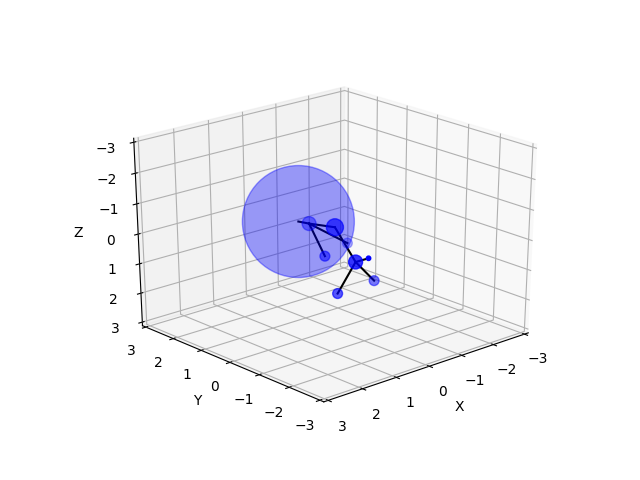

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


400 13.333333333333334
bump1
bump2


In [10]:
%matplotlib notebook
from numpy import *
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import juggle_axes

import scipy as sp
import scipy.integrate


# # Álgebra de quaternions:

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return array([w, x, y, z])

def q_conjugate(q):
    return [q[0], -q[1], -q[2], -q[3]]

def rotate(q, v):
    q = normalize(q)
    vec = concatenate(([0.0], v))
    return q_mult(q_mult(q, vec), q_conjugate(q))[1:]

def normalize(q, tolerance=1e-5):
    magnitude2 = sum(x * x for x in q)

    if abs(magnitude2 - 1.0) > tolerance:
        magnitude = sqrt(magnitude2)
        q = array([x / magnitude for x in q])

    return q

def ax2quaternion(v, theta):
    q = [0]*4
    v = normalize(v)
    q[0] = cos(theta/2.0)

    q[1] = v[0] * sin(theta/2.0)
    q[2] = v[1] * sin(theta/2.0)
    q[3] = v[2] * sin(theta/2.0)
    return q


# # Mêcanica:

def getInertiaTensor(r, masses):
    # r = positions vectors
    I = zeros((3,3))
    for i in range(0, len(masses)):
        I[0][0] += masses[i]*(r[i][1]*r[i][1] + r[i][2]*r[i][2])
        I[1][1] += masses[i]*(r[i][0]*r[i][0] + r[i][2]*r[i][2])
        I[2][2] += masses[i]*(r[i][0]*r[i][0] + r[i][1]*r[i][1])

        I[0][1] += -masses[i]*r[i][0]*r[i][1]
        I[0][2] += -masses[i]*r[i][0]*r[i][2]
        I[1][2] += -masses[i]*r[i][1]*r[i][2]

    I[1][0] = I[0][1]
    I[2][0] = I[0][2]
    I[2][1] = I[1][2]

    return I

def getInternalAngularMomentum(Q, v, masses):
    s = array([0,0,0])
    for i, m in enumerate(masses):
        s = s + m*cross(Q[i], v[i])
    return s

def CM(r,m):
    cm = array([0]*3)
    for i in range(len(r)):
        cm[0] += m[i]* r[i][0]
        cm[1] += m[i]* r[i][1]
        cm[2] += m[i]* r[i][2]
    cm = (1.0/sum(m))*cm
    return cm


# # Dados iniciais:

#Initialize data
#num_of_masses = 9
#masses = array([1, 1, 0.6, 0.6, 1.5, 1, 0.6, 0.6, 1])*50

#r_0 = [None]*num_of_masses

#r_0[0] = [0, -1.2, -0.5] # Head
#r_0[1] = [0, -1, 0] # Neck
#r_0[2] = [-1,-1,1] # Leg 1
#r_0[3] = [1, -1,1] #Leg 2
#r_0[4] = [0,0,0] # Center of body
#r_0[5] = [0,1,0] # Ribs
#r_0[6] = [-1,1, 1] #Leg 3
#r_0[7] = [1,1, 1] #Leg 4
#r_0[8] = [0, 1.5, -0.3] #Tail
#r_0 = array(r_0)


# a block
masses = array([3, 2, 1, 1, 0.2, 2, 1, 1, 130])*50
print("number of masses: ", len(masses))

r_0 = [None]*len(masses)

r_0[0] = [0, 0, 0] #centro do corpo

r_0[1] = [0, -1, 0] #parte de trás 
r_0[2] = [0.5,  -1, 1] #pata tras 1 
r_0[3] = [-0.5, -1, 1] # pata trás 2
r_0[4] = [0, -1.5, -0.5] #cauda
 
r_0[5] = [0,  1, 0]  #parte da frente
r_0[6] = [0.5, 1, 1] #pata frente 1 
r_0[7] = [-0.5, 1,1] #pata frente 2
r_0[8] = [0, 1.2, -0.2] #cabeça

r_0 = array(r_0)


#Lines between each part of the body
#Only used in animation
body_lines = [
    (0, 1),
    (1, 2),
    (1, 3),
    (1, 4),

    (0, 5),
    (5, 6),
    (5, 7),
    (5, 8),
]



#translacao para deixar o centro de massa na origem
r_cm = CM(r_0, masses)
for i in range(len(r_0)):
    r_0[i] = r_0[i] - r_cm


print('cm gato', r_cm )

# Teste no caso de 3 pontos
"""
masses = array([50.,50.,50.])
r_0[0] = [0, -1.7, 0.3]
r_0[1] = [0,0,0]
r_0[2] = [0, 1.2, 0.6]

"""

q_0 = [1,0,0,0] #Identity rotation
p_0 = [0,0,0] #Cat starts without moving
tmax = 10.0
num_times= 400
time = linspace(0.0, tmax, num_times)
r = [0 for i in range(0,len(masses))]

for i in range(0,len(masses)):
    r[i] = lambda t, i=i: r_0[i, :]


tmax_r1 = tmax/20.
ang_max = -pi/6.
freq = 2*pi/(tmax - tmax_r1)
for i in (1,2,3,4):
    def ri(t, j=i):
        if t < tmax_r1:
            return rotate( ax2quaternion(array([1,0,0]), t*ang_max/tmax_r1), r_0[j, :] )
        else:
            rx = rotate( ax2quaternion(array([1,0,0]), ang_max), r_0[j, :] )
            axis = rotate( ax2quaternion(array([1,0,0]), ang_max), r_0[1, :] ) -  rotate( ax2quaternion(array([1,0,0]), ang_max), r_0[0, :] )

            return rotate( ax2quaternion( axis, freq*(t - tmax_r1)), rx)
    r[i] = ri

for i in (5,6,7,8):
    def ri(t, j=i):
        if t < tmax_r1:
            return rotate( ax2quaternion(array([1,0,0]), -t*ang_max/tmax_r1), r_0[j, :] )
        else:
            rx = rotate( ax2quaternion(array([1,0,0]), -ang_max), r_0[j, :] )
            axis = rotate( ax2quaternion(array([1,0,0]), -ang_max), r_0[5, :] ) -  rotate( ax2quaternion(array([1,0,0]), -ang_max), r_0[0, :] )

            return rotate( ax2quaternion( axis, -freq*(t - tmax_r1)), rx) 

    r[i] = ri


#for i in (0,2,3):
    #r[i] = lambda t, i=i: rotate(ax2quaternion(r_0[1]-r_0[4], 1.5*pi*t/tmax), r_0[i, :])

#for i in (6,7,8):
    #r[i] = lambda t, i=i: rotate(ax2quaternion(r_0[5]-r_0[4], 1.5*pi*t/tmax), r_0[i, :])




def particles(t):
    a = empty([len(masses), 3])
    for i in range(0,len(masses)):
        a[i] = r[i](t)
    return a


# # Equações de movimento:
#
# $$ \frac{dp}{dt}(t) = p(t) \times I^{-1}(t) \left( p(t) - L_0(t) \right) $$
    # $$ \omega = I^{-1} \left( p - L_0 \right) $$
    #
#
# E dado $\omega \in \mathbb{R}^3$ podemos achar uma rotação $q$ tal que:
#
#
# $$ \frac{dq}{dt} = \frac{1}{2} q \omega $$
#


def eqOfMotion(x, t, I, L_0):
    #Rotation
    q = array(x[:4])
    #Body angular momentum
    p = array(x[4:])

    #Positions at instant t
    pos = particles(t)
    #Velocities at instant t
    ep = 1e-7
    v = (particles(t+ep) - particles(t-ep) ) / (2*ep)


    #Tensor of inertia
    A = I(pos, masses)
    Iinv = linalg.inv(A)

    #Angular Momentum
    L = L_0(pos, v, masses)
    dp_dt = cross(dot(Iinv,p), (p-L))

    omega = dot(Iinv, (p - L))
    dq_dt = 0.5 * q_mult(q, concatenate(([0.0], omega)))

    return [dq_dt[0], dq_dt[1], dq_dt[2], dq_dt[3]] + [dp_dt[0], dp_dt[1], dp_dt[2]]


# Get the body angular momentum
# P == momento angular do corpo


args = (getInertiaTensor, getInternalAngularMomentum)
q = sp.integrate.odeint(eqOfMotion, q_0 + p_0, time, args)
q = transpose(q)
q = q[:4, :]


# # Achar posições da rotação:
# Dadas posições no ponto de vista da partícula e rotações encontradas, queremos:
#
# $$ r_i(t) = R(t)r_{i0}(t) = q(t) r_{i0}(t) \bar{q}(t) $$
#
#

positions = empty([len(masses), 3, num_times])

for k, rot in enumerate(transpose(q)):
    t = k*tmax/num_times
    p = particles(t)
    for i in range(0,len(masses)):
        # Sistema inercial
        positions[i,:, k] = rotate(rot, p[i, :]) + r_cm
        # Sistema do corpo
        #positions[i,:, k] = p[i, :]


# # It's plotting time!


# Animation function
def update_plot(num, positions, body_lines, ani_lines, sc):
    t = tmax*num/num_times

    for line, (sp, ep) in zip(ani_lines, body_lines):
        line._verts3d = positions[[sp,ep], :, num].T.tolist()

    sc._offsets3d = juggle_axes(positions[:,0, num], positions[:,1, num], positions[:,2, num], 'z')
    return sc

#Create figure object and set animation
fig = figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d([-3.0, 3.0])
ax.set_ylim3d([-3.0, 3.0])
ax.set_zlim3d([-3.0, 3.0])
#ax.grid()


# Lines between parts of cat

ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]


sc = ax.scatter3D(positions[:,0, 0], positions[:,1, 0], positions[:,2, 0], marker='o', c='b', s=masses)



ani = FuncAnimation(fig, update_plot,  frames=len(time), interval=2,
        fargs=(positions, body_lines, ani_lines, sc), repeat=True)

print(len(time), len(time)/30.0)
print("bump1")
show()
ani.save('./animation.gif', writer='imagemagick', fps=30)
print("bump2")


In [2]:
positions

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          5.71995021e-02,  5.97700688e-02,  6.23358081e-02],
        [ 0.00000000e+00,  2.11433166e-04,  4.22911067e-04, ...,
          3.55919694e-02,  3.55726423e-02,  3.55466895e-02],
        [ 0.00000000e+00, -7.30757761e-05, -1.46021883e-04, ...,
          5.86892674e-01,  5.86379535e-01,  5.85842629e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.59457038e-02, -3.40129434e-02, -4.20733462e-02],
        [-1.00000000e+00, -1.00705472e+00, -1.01339179e+00, ...,
         -1.02585745e+00, -1.02588725e+00, -1.02586218e+00],
        [ 0.00000000e+00,  2.81110701e-02,  5.63925639e-02, ...,
          1.28328339e-01,  1.30028276e-01,  1.31764996e-01]],

       [[ 5.00000000e-01,  4.99999959e-01,  4.99999959e-01, ...,
         -7.33420184e-01, -7.33597057e-01, -7.33709163e-01],
        [-1.00000000e+00, -9.81603489e-01, -9.62505811e-01, ...,
         -6.39131701e-01, -6.34803043e-01, -6.305